#PhlyGreen Tutorial 

Import packages

In [1]:
import sys
import PhlyGreen as pg
import numpy as np
import matplotlib.pyplot as plt

Create instances of subsystems. Each one of those requires an Aircraft object as argument. By passing (None) as argument, we are creating empty objects (for the moment).

In [2]:
powertrain = pg.Systems.Powertrain.Powertrain(None)
structures = pg.Systems.Structures.Structures(None)
aerodynamics = pg.Systems.Aerodynamics.Aerodynamics(None)
performance = pg.Performance.Performance(None)
mission = pg.Mission.Mission(None)
weight = pg.Weight.Weight(None)
constraint = pg.Constraint.Constraint(None)
welltowake = pg.WellToWake.WellToWake(None)

Create instance of Aircraft object.

In [3]:
myaircraft = pg.Aircraft(powertrain, structures, aerodynamics, performance, mission, weight, constraint, welltowake)

Create the connections with its subsystems.

In [4]:
powertrain.aircraft = myaircraft
structures.aircraft = myaircraft
aerodynamics.aircraft = myaircraft
mission.aircraft = myaircraft
performance.aircraft = myaircraft
weight.aircraft = myaircraft
constraint.aircraft = myaircraft
welltowake.aircraft = myaircraft

Define input dictionaries

Constraints ordering:
[0] : cruise,
[1] : take-off,
[2] : climb,
[3] : turn,
[4] : ceiling,
[5] : acceleration,
[6] : landing 

In [5]:
ConstraintsInput = {'speed': np.array([0.4, 160, 200, 210, 0.5, 0.35, 104.]) ,
                    'speedtype': ['Mach','KCAS','KCAS','KCAS','Mach','Mach','KCAS']   ,
                    'beta': np.array([0.95,0.985,0.97, 0.9, 0.8, 0.9, None])   ,
                    'altitude': np.array([8000., 100., 6000., 5000, 9500., 6000, 500.]),
                    'load factor': np.array([1., None, 1., 1.1, 1., 1., None]),
                    'DISA': 0, 
                    'kTO': 1.2,
                    'sTO': 850,
                    'OEI Climb Gradient': 0.021,
                    'Rate of Climb': 5,  #5m/s ~= 1000 ft/min, 7.6 ~= 1500 ft/min
                    'ht': 0.5,
                    'M1': 0.3,
                    'M2': 0.4,
                    'DTAcceleration': 180}

In [6]:
MissionInput = {'Range Mission': 750,  #nautical miles
                'Range Diversion': 220,  #nautical miles
                'Beta start': 0.985,
                'Payload Weight': 4560,  #Kg
                'Crew Weight': 500}  #Kg

In [7]:
MissionStages = {'Climb1': {'type': 'ConstantRateClimb', 'input': {'CB': 0.16, 'Speed': 77, 'StartAltitude': 100, 'EndAltitude': 1500}, 'Supplied Power Ratio':{'phi_start': 0.0, 'phi_end':0.0 }},
                 'Climb2': {'type': 'ConstantRateClimb', 'input': {'CB': 0.08, 'Speed': 120, 'StartAltitude': 1500, 'EndAltitude': 4500}, 'Supplied Power Ratio':{'phi_start': 0.0, 'phi_end':0.0 }},
                 'Climb3': {'type': 'ConstantRateClimb', 'input': {'CB': 0.07, 'Speed': 125, 'StartAltitude': 4500, 'EndAltitude': 8000}, 'Supplied Power Ratio':{'phi_start': 0.0, 'phi_end':0.0 }},
                 'Cruise': {'type': 'ConstantMachCruise', 'input':{ 'Mach': 0.4, 'Altitude': 8000}, 'Supplied Power Ratio':{'phi_start': 0.0, 'phi_end':0.0 }},
                 'Descent1': {'type': 'ConstantRateDescent', 'input':{'CB': -0.04, 'Speed': 90, 'StartAltitude': 8000, 'EndAltitude': 200}, 'Supplied Power Ratio':{'phi_start': 0.0, 'phi_end':0.0 }}}

DiversionStages = {'Climb1': {'type': 'ConstantRateClimb', 'input': {'CB': 0.08, 'Speed': 110, 'StartAltitude': 200, 'EndAltitude': 3100}, 'Supplied Power Ratio':{'phi_start': 0.0, 'phi_end':0.0 }},
                 'Cruise': {'type': 'ConstantMachCruise', 'input':{ 'Mach': 0.35, 'Altitude': 3100}, 'Supplied Power Ratio':{'phi_start': 0.0, 'phi_end':0.0}},
                 'Descent1': {'type': 'ConstantRateDescent', 'input':{'CB': -0.04, 'Speed': 90, 'StartAltitude': 3100, 'EndAltitude': 200}, 'Supplied Power Ratio':{'phi_start': 0.0, 'phi_end':0.0 }}}

In [8]:
EnergyInput = {'Ef': 43.5*10**6,
                   'Eta Gas Turbine Model': 'PW127',
                   #'Eta Gas Turbine': 0.22,
                   'Eta Gearbox': 0.96,
                   'Eta Propulsive Model': 'constant',
                   'Eta Propulsive': 0.87,
                   'Specific Power Powertrain': [3900,0]  # W/Kg
                   }

In [9]:
AerodynamicsInput = {'NumericalPolar': {'type': 'ATR42'}}

Import input dictionaries

In [10]:
myaircraft.ConstraintsInput = ConstraintsInput
myaircraft.AerodynamicsInput = AerodynamicsInput
myaircraft.MissionInput = MissionInput
myaircraft.MissionStages = MissionStages
myaircraft.DiversionStages = DiversionStages
myaircraft.EnergyInput = EnergyInput

Set aircraft power configuration

In [11]:
myaircraft.Configuration = 'Traditional'

Set inputs

In [12]:
# Initialize Constraint Analysis
myaircraft.constraint.SetInput()

# Initialize Mission profile and Analysis
myaircraft.mission.InitializeProfile()
myaircraft.mission.SetInput()

# Initialize Aerodynamics subsystem
myaircraft.aerodynamics.SetInput()

# Initialize Powertrain
myaircraft.powertrain.SetInput()

# Initialize Weight Estimator
myaircraft.weight.SetInput()

/Users/riccardo/opt/anaconda3/envs/PhlyGreen/lib/python3.12/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator LinearRegression from version 1.3.0 when using version 1.3.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Either run the Constraint Analysis....

In [13]:
myaircraft.constraint.FindDesignPoint()
print('----------------------------------------')
print('Design W/S: ',myaircraft.DesignWTOoS)
print('Design P/W: ',myaircraft.DesignPW)
print('----------------------------------------')

----------------------------------------
Design W/S:  3328.8528528528527
Design P/W:  196.39949805401488
----------------------------------------


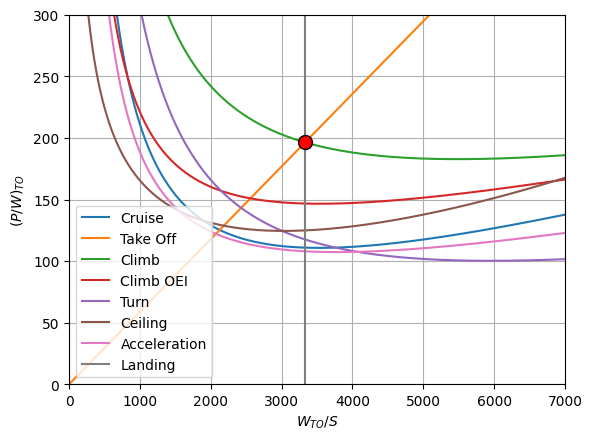

In [14]:
plt.plot(myaircraft.constraint.WTOoS,myaircraft.constraint.PWCruise, label='Cruise')
plt.plot(myaircraft.constraint.WTOoS,myaircraft.constraint.PWTakeOff, label='Take Off')
plt.plot(myaircraft.constraint.WTOoS,myaircraft.constraint.PWClimb, label='Climb')
plt.plot(myaircraft.constraint.WTOoS,myaircraft.constraint.PWOEI, label='Climb OEI')
plt.plot(myaircraft.constraint.WTOoS,myaircraft.constraint.PWTurn, label='Turn')
plt.plot(myaircraft.constraint.WTOoS,myaircraft.constraint.PWCeiling, label='Ceiling')
plt.plot(myaircraft.constraint.WTOoS,myaircraft.constraint.PWAcceleration, label='Acceleration')
plt.plot(myaircraft.constraint.WTOoSLanding,myaircraft. constraint.PWLanding, label='Landing')
plt.plot(myaircraft.DesignWTOoS, myaircraft.DesignPW, marker='o', markersize = 10, markerfacecolor = 'red', markeredgecolor = 'black')
# plt.plot(performance.WTOoSTorenbeek, performance.PWTorenbeek, label='Torenbeek')
plt.ylim([0, 300])
plt.xlim([0, 7000])
plt.legend()
plt.grid(visible=True)
plt.xlabel('$W_{TO}/S$')
plt.ylabel('$(P/W)_{TO}$')
plt.show()

Run Mission analysis to define the aircraft's masses

In [15]:
myaircraft.weight.WeightEstimation()

Wing surface can be readily estimated as S = WTO/(WTO/S)

In [16]:
myaircraft.WingSurface = myaircraft.weight.WTO / myaircraft.DesignWTOoS * myaircraft.performance.g_acc 

A summary of the preliminary design:

In [17]:
print('----------------------------------------')
print('Fuel mass (trip + altn) [Kg]: ', myaircraft.weight.Wf)
print('Block Fuel mass [Kg]:         ', myaircraft.weight.Wf + myaircraft.weight.final_reserve)
print('Structure [Kg]:               ', myaircraft.weight.WStructure)
print('Powertrain mass [Kg]:         ',myaircraft.weight.WPT)
print('Empty Weight [Kg]:            ', myaircraft.weight.WPT + myaircraft.weight.WStructure + myaircraft.weight.WCrew)
print('Zero Fuel Weight [Kg]:        ', myaircraft.weight.WPT + myaircraft.weight.WStructure + myaircraft.weight.WCrew + myaircraft.weight.WPayload)
print('----------------------------------------')
print('Takeoff Weight [Kg]:          ', myaircraft.weight.WTO)
if myaircraft.WellToTankInput is not None:
    print('Source Energy: ', myaircraft.welltowake.SourceEnergy/1.e6,' MJ')
    print('Psi: ', myaircraft.welltowake.Psi)
print('Wing Surface [m^2]: ', myaircraft.WingSurface)
print('TakeOff shaft peak power [kW]:      ', myaircraft.mission.TO_PP/1000.)
print('Climb/cruise shaft peak power [kW]: ', myaircraft.mission.Max_PEng/1000.)
print('Sizing phase for thermal powertrain: ', 'Climb/Cruise peak power' if myaircraft.mission.Max_PEng > myaircraft.mission.TO_PP else 'Takeoff peak power'  )

----------------------------------------
Fuel mass (trip + altn) [Kg]:  1630.0587660030349
Block Fuel mass [Kg]:          2130.058766003035
Structure [Kg]:                10340.24378522249
Powertrain mass [Kg]:          1123.9485999431924
Empty Weight [Kg]:             11964.192385165683
Zero Fuel Weight [Kg]:         16524.192385165683
----------------------------------------
Takeoff Weight [Kg]:           18654.28413223453
Wing Surface [m^2]:  54.97345044266213
TakeOff shaft peak power [kW]:       4383.39953977845
Climb/cruise shaft peak power [kW]:  3698.224654514206
Sizing phase for thermal powertrain:  Takeoff peak power


Some plots:

In [18]:
times = np.array([])
Ef = np.array([])
beta = np.array([])
for array in mission.integral_solution:
    times = np.concatenate([times, array.t])
    Ef = np.concatenate([Ef, array.y[0]])
    beta = np.concatenate([beta, array.y[1]])

Take-Off Propulsive Power over Takeoff Mass

In [19]:
myaircraft.performance.TakeOff(myaircraft.DesignWTOoS,myaircraft.constraint.ConstraintsBeta[1], myaircraft.constraint.ConstraintsAltitude[1], myaircraft.constraint.kTO, myaircraft.constraint.sTO, myaircraft.constraint.DISA, myaircraft.constraint.ConstraintsSpeed[1], myaircraft.constraint.ConstraintsSpeedtype[1])

196.25653187748546

Maximum mission Propusive Power over Takeoff Mass

In [20]:
max([myaircraft.performance.PoWTO(myaircraft.DesignWTOoS,beta[t],myaircraft.mission.profile.PowerExcess(times[t]),1,myaircraft.mission.profile.Altitude(times[t]),myaircraft.mission.DISA,myaircraft.mission.profile.Velocity(times[t]),'TAS') for t in range(len(times))])

165.57941803211807

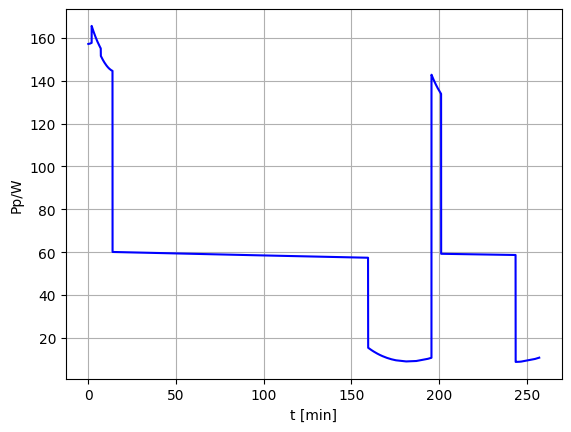

In [21]:
plt.plot(times/60,[myaircraft.performance.PoWTO(myaircraft.DesignWTOoS,beta[t],myaircraft.mission.profile.PowerExcess(times[t]),1,myaircraft.mission.profile.Altitude(times[t]),myaircraft.mission.DISA,myaircraft.mission.profile.Velocity(times[t]),'TAS') for t in range(len(times))], 'b')
plt.grid(visible=True)
plt.xlabel('t [min]')
plt.ylabel('Pp/W')
plt.show()

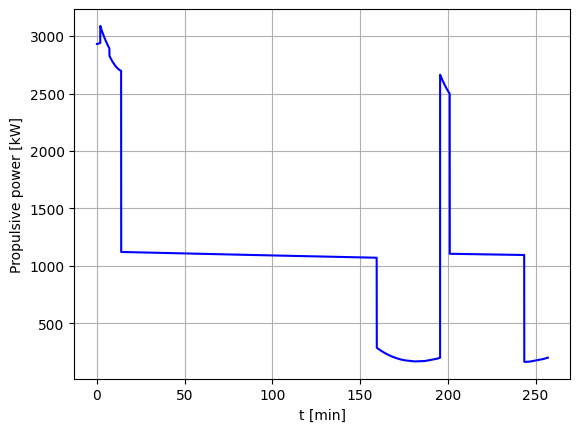

In [22]:
plt.plot(times/60,[(myaircraft.weight.WTO/1000) * myaircraft.performance.PoWTO(myaircraft.DesignWTOoS,beta[t],myaircraft.mission.profile.PowerExcess(times[t]),1,myaircraft.mission.profile.Altitude(times[t]),myaircraft.mission.DISA,myaircraft.mission.profile.Velocity(times[t]),'TAS') for t in range(len(times))], 'b')
# pwsd[t]= 1e-3*0.5*0.89*(myaircraft.weight.WTO/1000) * myaircraft.performance.PoWTO(myaircraft.DesignWTOoS,beta[t],myaircraft.mission.profile.PowerExcess(times[t]),1,myaircraft.mission.profile.Altitude(times[t]),myaircraft.mission.DISA,myaircraft.mission.profile.Velocity(times[t]),'TAS') for t in range(len(times))
plt.grid(visible=True)
plt.xlabel('t [min]')
plt.ylabel('Propulsive power [kW]')
plt.show()

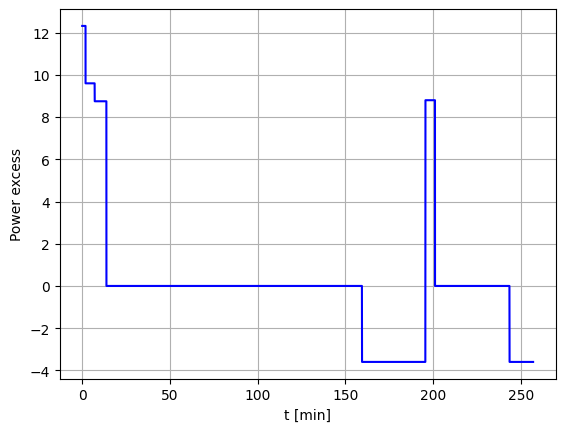

In [23]:
plt.plot(times/60,[myaircraft.mission.profile.PowerExcess(times[t]) for t in range(len(times))], 'b')
# pwsd[t]= 1e-3*0.5*0.89*(myaircraft.weight.WTO/1000) * myaircraft.performance.PoWTO(myaircraft.DesignWTOoS,beta[t],myaircraft.mission.profile.PowerExcess(times[t]),1,myaircraft.mission.profile.Altitude(times[t]),myaircraft.mission.DISA,myaircraft.mission.profile.Velocity(times[t]),'TAS') for t in range(len(times))
plt.grid(visible=True)
plt.xlabel('t [min]')
plt.ylabel('Power excess')
plt.show()

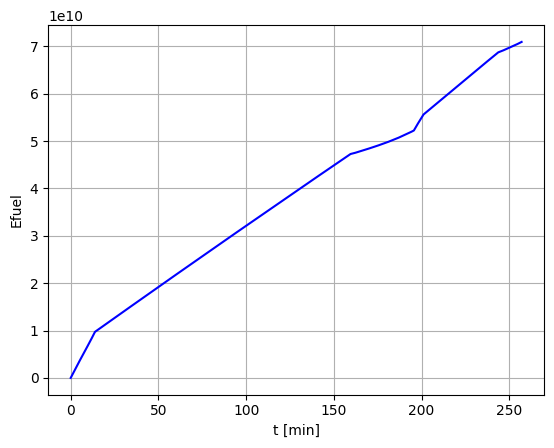

In [24]:
plt.plot(times/60,Ef, 'b')
#plt.plot(myaircraft.mission.profile.Breaks,np.ones(6)*0.05, '*')
plt.grid(visible=True)
plt.xlabel('t [min]')
plt.ylabel('Efuel')
plt.show()

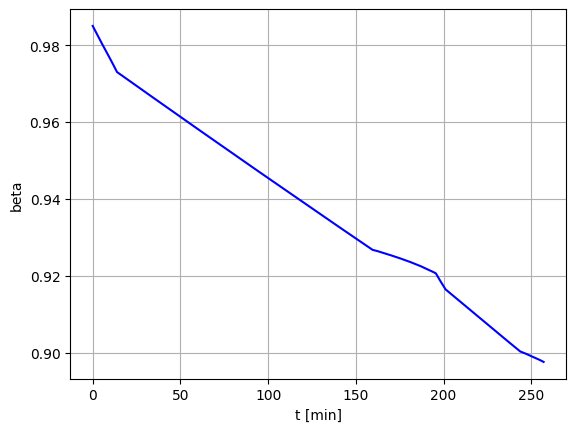

In [25]:
plt.plot(times/60,beta, 'b')
#plt.plot(myaircraft.mission.profile.Breaks,np.ones(6)*0.05, '*')
plt.grid(visible=True)
plt.xlabel('t [min]')
plt.ylabel('beta')
plt.show()

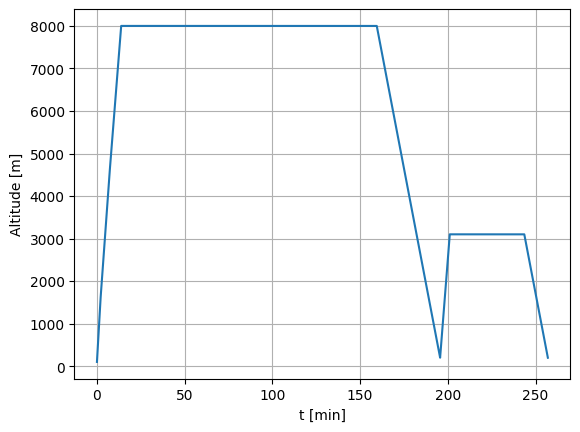

In [26]:
plt.plot(times/60,mission.profile.Altitude(times))
plt.grid(visible=True)
plt.xlabel('t [min]')
plt.ylabel('Altitude [m]')
plt.show()

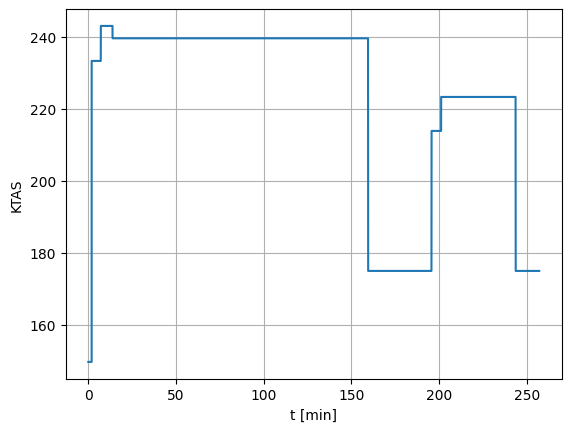

In [27]:
plt.plot(times/60,pg.Utilities.Units.MtoKN(mission.profile.Velocity(times)))
plt.grid(visible=True)
plt.xlabel('t [min]')
plt.ylabel('KTAS')
plt.show()

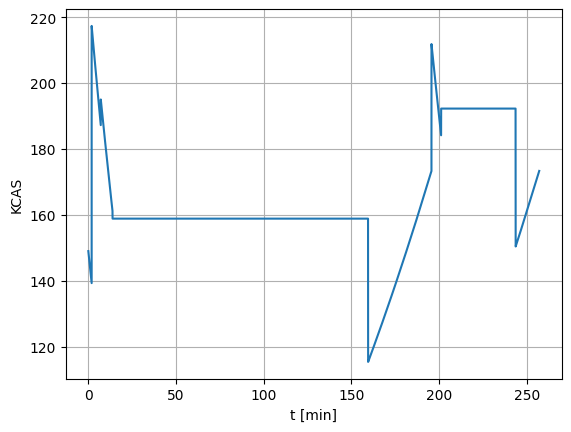

In [28]:
plt.plot(times/60,[pg.Utilities.Units.MtoKN(pg.Utilities.Speed.TAS2CAS(mission.profile.Velocity(t),mission.profile.Altitude(t))) for t in times])
plt.grid(visible=True)
plt.xlabel('t [min]')
plt.ylabel('KCAS')
plt.show()

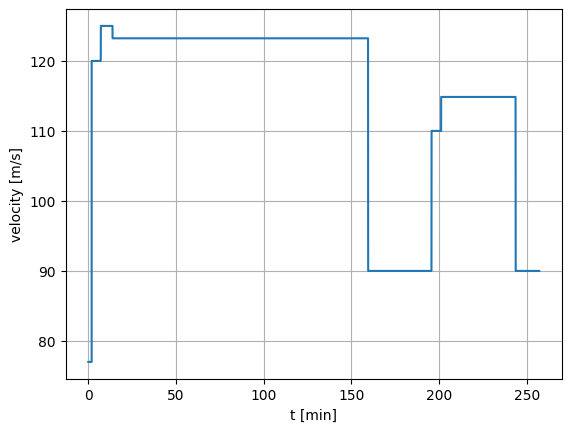

In [29]:
plt.plot(times/60,mission.profile.Velocity(times))
plt.grid(visible=True)
plt.xlabel('t [min]')
plt.ylabel('velocity [m/s]')
plt.show()

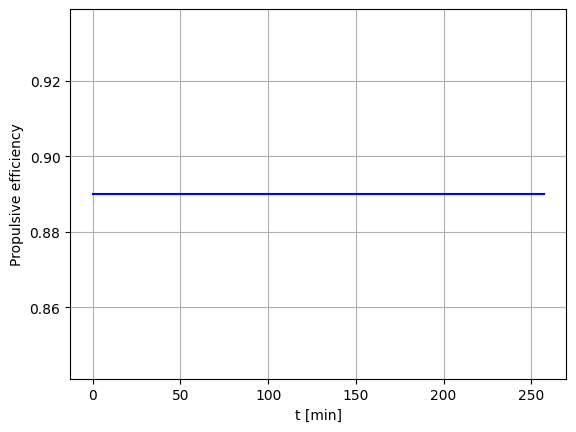

In [30]:
etaPP = np.zeros(len(times))
for t in range(len(times)):
    alt = myaircraft.mission.profile.Altitude(times[t])
    v = myaircraft.mission.profile.Velocity(times[t])
    power = (myaircraft.weight.WTO) * myaircraft.performance.PoWTO(myaircraft.DesignWTOoS,beta[t],myaircraft.mission.profile.PowerExcess(times[t]),1,alt,myaircraft.mission.DISA,v,'TAS')
    etaPP[t]= myaircraft.powertrain.EtaPPpw127Model(alt, v, power)
plt.plot(times/60,etaPP, 'b')
plt.grid(visible=True)
plt.xlabel('t [min]')
plt.ylabel('Propulsive efficiency')
plt.show()

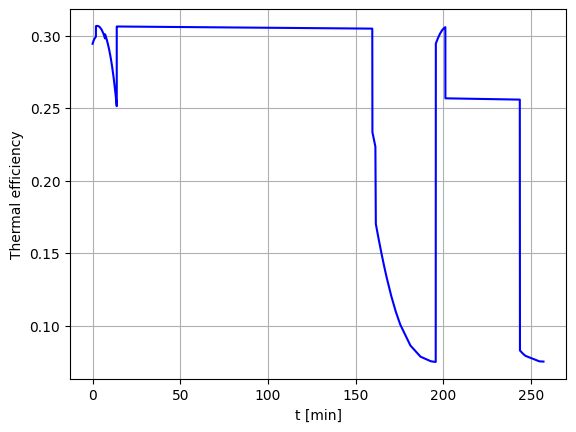

In [31]:
if myaircraft.EnergyInput['Eta Gas Turbine Model'] == 'PW127':
    etaTh = np.zeros(len(times))
    for t in range(len(times)):
        alt = myaircraft.mission.profile.Altitude(times[t])
        v = myaircraft.mission.profile.Velocity(times[t])
        power = (myaircraft.weight.WTO) * myaircraft.performance.PoWTO(myaircraft.DesignWTOoS,beta[t],myaircraft.mission.profile.PowerExcess(times[t]),1,alt,myaircraft.mission.DISA,v,'TAS')
        etaTh[t]= myaircraft.powertrain.EtaGTpw127Model(alt, v, power)
    plt.plot(times/60,etaTh, 'b')
    plt.grid(visible=True)
    plt.xlabel('t [min]')
    plt.ylabel('Thermal efficiency')
    plt.show()

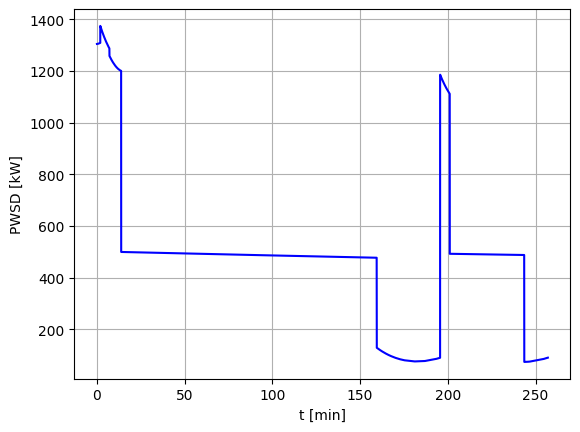

In [32]:
pwsd = np.zeros(len(times))
for t in range(len(times)):
    alt = myaircraft.mission.profile.Altitude(times[t])
    v = myaircraft.mission.profile.Velocity(times[t])
    power = (myaircraft.weight.WTO) * myaircraft.performance.PoWTO(myaircraft.DesignWTOoS,beta[t],myaircraft.mission.profile.PowerExcess(times[t]),1,alt,myaircraft.mission.DISA,v,'TAS')
    pwsd[t]= 1e-3*0.5*0.89*power
plt.plot(times/60,pwsd, 'b')
plt.grid(visible=True)
plt.xlabel('t [min]')
plt.ylabel('PWSD [kW]')
plt.show()

Compute Payload - Range diagram


In [33]:
from scipy.optimize import brenth 

In [34]:
maxFuelCapacity = 4000 #Kg (4000 + final reserve)
MTOW = myaircraft.weight.WTO #Kg
OEW = myaircraft.weight.WPT + myaircraft.weight.WStructure + myaircraft.weight.WCrew + myaircraft.weight.final_reserve #Kg 
MZFW =OEW + myaircraft.weight.WPayload #Kg 
WPayload = 4560 #Kg
wfuel = myaircraft.weight.Wf
designRange = 750 #nm

drng = 10 #nm

In [35]:
def funcNL(Wf, WPayload):
     return Wf - myaircraft.mission.EvaluateMission(OEW + WPayload+ Wf)/myaircraft.weight.ef

In [36]:
#1 non-limited range
missionRangeNL = np.linspace(150,designRange,num=50, endpoint=True) 
wfuelNL = []
for rng in missionRangeNL:
    newmission = pg.Mission.Mission(myaircraft)
    myaircraft.mission = newmission
    myaircraft.MissionInput['Range Mission'] = rng
    myaircraft.mission.InitializeProfile()
    myaircraft.mission.SetInput()
    wfuelNL.append(brenth(funcNL, 0, maxFuelCapacity, args=(WPayload), xtol=0.01) )

In [37]:
def funcTOL(WPayload, MTOW):
     return MTOW - (OEW + WPayload + myaircraft.mission.EvaluateMission(MTOW)/myaircraft.weight.ef)

In [38]:
#2 - MTOW-limited range
rng = designRange
wpayloadTOL = []
wfuelTOL = []
missionRangeTOL = []
while wfuel < maxFuelCapacity:
    newmission = pg.Mission.Mission(myaircraft)
    myaircraft.mission = newmission
    myaircraft.MissionInput['Range Mission'] = rng
    myaircraft.mission.InitializeProfile()
    myaircraft.mission.SetInput()
    wpayloadTOL.append( brenth(funcTOL, 0, MTOW, args=(MTOW), xtol=0.01) )
    missionRangeTOL.append(rng)
    wfuel = MTOW - ( wpayloadTOL[-1] + OEW) 
    wfuelTOL.append(wfuel)
    rng = rng + drng

In [39]:
def funcFCL(WPayload, OEW, maxFuelCapacity):
     return maxFuelCapacity - myaircraft.mission.EvaluateMission(OEW+WPayload+maxFuelCapacity)/myaircraft.weight.ef

In [40]:
#3 - Fuel capacity-limited range
wpload = wpayloadTOL[-1]
rng = missionRangeTOL[-1]
wpayloadFCL = []
missionRangeFCL = []
while wpload > 300:
    newmission = pg.Mission.Mission(myaircraft)
    myaircraft.mission = newmission
    myaircraft.MissionInput['Range Mission'] = rng
    myaircraft.mission.InitializeProfile()
    myaircraft.mission.SetInput()
    wpayloadFCL.append(brenth(funcFCL, 0, WPayload, args=(OEW, maxFuelCapacity), xtol=0.01) )
    wpload = wpayloadFCL[-1] 
    missionRangeFCL.append(rng)
    rng = rng + drng

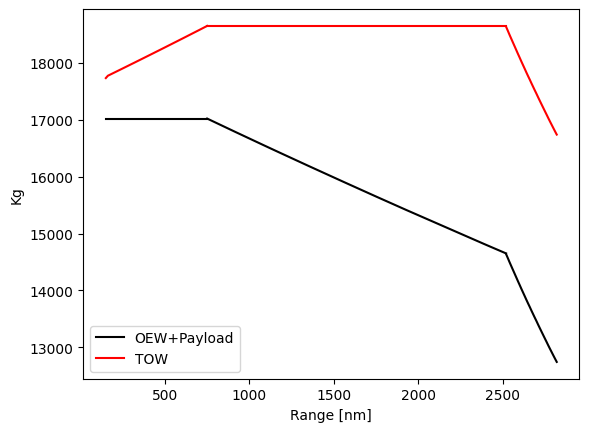

In [41]:
plt.plot(missionRangeNL,[MZFW for i in range(len(missionRangeNL))],color='black',label='OEW+Payload')
plt.plot(missionRangeNL,np.add(MZFW,wfuelNL),color='red',label='TOW')
plt.plot(missionRangeTOL,np.subtract(MTOW,wfuelTOL),color='black')
plt.plot(missionRangeTOL,[MTOW for i in range(len(missionRangeTOL))],color='red')
plt.plot(missionRangeFCL,np.add(OEW,wpayloadFCL),color='black')
plt.plot(missionRangeFCL,np.add(OEW+maxFuelCapacity,wpayloadFCL),color='red')
plt.xlabel('Range [nm]')
plt.ylabel('Kg')
plt.legend()